The idea is to implement here an architecture similar to the one developed in "Datadriven wind turbine wake modeling via probabilistic Machine Learning":
- autoencoder trained on the output wake field
- MLP from input to latent space which is then plugged to the trained decoder to obtain the actual desired output

In [7]:
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
from collections import defaultdict
import time
import matplotlib.pyplot as plt
#import seaborn as sns
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from data_loaders import get_wake_dataloaders

In [8]:
DATAFRAME_FILEPATH = "data/discr_factors_x2_50_y-1_1_step0.125/"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

# hyperparameters
BATCH_SIZE = 2
LR = 1e-2
WD = 1e-5 # weight decay
EPOCHS = 10

BOTTLENECK_SPACE = 5

In [10]:
train_dataloader, test_dataloader = get_wake_dataloaders(DATAFRAME_FILEPATH,
                                                          consider_ws=False,
                                                          coords_as_input=True,
                                                          train_perc=0.8,
                                                          test_perc=0.2,
                                                          batch_size=BATCH_SIZE)
len(train_dataloader)

5283840

In [11]:
class AutoEncoder(nn.Module):

    def __init__(self, field_shape: int):
        super(AutoEncoder, self).__init__()
        self.field_shape = field_shape
        
        self.encoder = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(field_shape[0] * field_shape[1], 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, BOTTLENECK_SPACE),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(BOTTLENECK_SPACE, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, field_shape[0] * field_shape[1]),
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=(field_shape[0], field_shape[1]))
        )
    
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode
    

Link for Convolutional Autoencoder https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac

In [12]:
class UnsqueezeForChannel(nn.Module): #TODO
    def __init__(self):
        super(UnsqueezeForChannel, self).__init__()
    
    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        return x

class SqueezeForChannel(nn.Module): #TODO
    def __init__(self):
        super(SqueezeForChannel, self).__init__()
    
    def forward(self, x):
        x = torch.squeeze(x, 1)
        return x

#TODO delete
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        print(x.shape)
        return x

class ConvEncoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            UnsqueezeForChannel(),
            #PrintLayer(), # shape here: [N, C_in, H, W] = [batch_size, 1, H, W]
            # TODO change parameters of convolutional layers according also to the final grid shape
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            #PrintLayer(),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            #PrintLayer(),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            #PrintLayer(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            #PrintLayer()
        )
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(32 * 24 * 1, 128), #TODO change first argument according to the shape of the resulting tensor
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

class ConvDecoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 32 * 24 * 1), #TODO the second argument here must be the same of encoder_lin 2
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 24, 1)) #TODO the same as before?

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
            SqueezeForChannel()
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

class ConvAutoEncoder(nn.Module):
    def __init__(self, encoded_space_dim) -> None:
        super().__init__() 
        self.encoder = ConvEncoder(encoded_space_dim)
        self.decoder = ConvDecoder(encoded_space_dim)
    
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode

In [15]:
field_shape = train_dataloader.dataset.y.shape[1:]
print(f"{field_shape=}")

# standard autoencoder
autoencoder = AutoEncoder(field_shape).to(DEVICE)
# convolutional autoencoder
#autoencoder = ConvAutoEncoder(BOTTLENECK_SPACE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(autoencoder.parameters(), lr=LR)#, weight_decay=WD)

# train model
metrics = defaultdict(list)
outlier_loss = []
outlier_results = []

autoencoder.train()

start = time.time()
for epoch in range(EPOCHS):
    ep_start = time.time()
    running_loss = 0.0

    for batch in iter(train_dataloader):
        wake_field = batch[1].to(DEVICE) # only considering the wake field (not the input variables)
        reconstructed_wake_field = autoencoder(wake_field)
        loss = criterion(wake_field, reconstructed_wake_field)

        outlier_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    epoch_loss = running_loss/len(train_dataloader.dataset) #TODO
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.time()

    #print('-----------------------------------------------')
    print(f"{epoch=}/{EPOCHS}\t->Loss: {epoch_loss}")
    #print('\tEpoch Complete in {}'.format(timedelta(seconds=ep_end-ep_start)))

end = time.time()
print('-----------------------------------------------')
print('[System Complete: {}]'.format(timedelta(seconds=end-start)))

field_shape=torch.Size([1])


IndexError: tuple index out of range

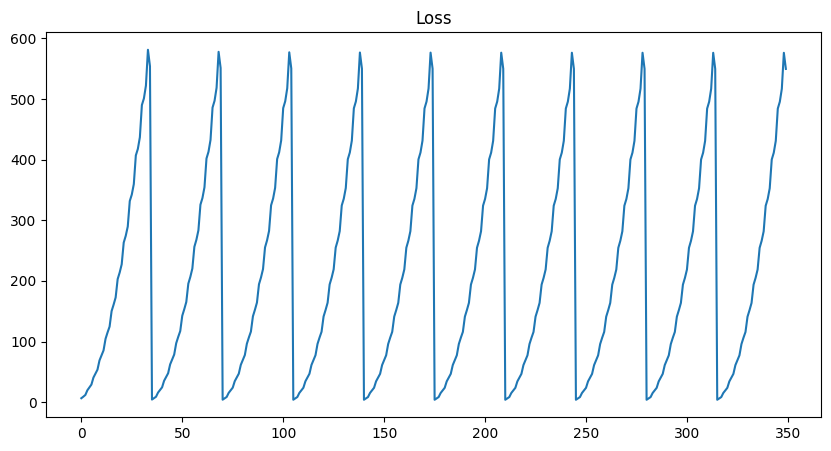

In [ ]:
_, ax = plt.subplots(1,1,figsize=(10,5))
ax.set_title('Loss')
ax.plot(outlier_loss)

# Second part: MLP from input to latent space which is then plugged to the decoder

For the training of this second part, there are two main options:
- to calculate the loss as the final difference between the reconstructed output and the ground truth output -> it may be unfair because it would evaluate also the capacity of the decoder to reconstruct the field from the latent space
- to calculate the loss on the latent space (output of this model and the output of the previously-trained encoder) -> it may be uncorrect because it would learn from the ground truth but from a latent space that is obtained from the trained encoder

In [ ]:
input_space = len(INPUT_VARIABLES)

model = nn.Sequential(
    nn.Linear(input_space, 15),
    nn.ReLU(),
    nn.Linear(15, 50),
    nn.ReLU(),
    nn.Linear(50, BOTTLENECK_SPACE),
    nn.ReLU() #TODO?
).to(DEVICE)



optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), lr=LR
)
loss_function = torch.nn.MSELoss() #TODO change

model.train()
autoencoder.eval()

print("Starting training")
epoch_to_loss_acc = dict()
for epoch in range(EPOCHS):
    epoch_loss = 0
    epoch_accs = torch.FloatTensor()
    for batch in iter(train_dataloader):
        x, y = batch[0].to(DEVICE), batch[1].to(DEVICE)

        bottleneck_pred = model.forward(x)
        bottleneck_truth = autoencoder.encoder(y)

        # loss and step
        loss = loss_function(bottleneck_pred, bottleneck_truth)
        #optimizer.zero_grad() TODO
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) TODO
        optimizer.step()

        epoch_loss += loss.item()

        #TODO accuracy or other metric computation

    print(f"{epoch=} -> {epoch_loss=}")
    epoch_to_loss_acc[epoch] = epoch_loss

epoch_to_loss_acc

Starting training
epoch=0 -> epoch_loss=1.0820805430412292
epoch=1 -> epoch_loss=1.104063667356968
epoch=2 -> epoch_loss=1.0685909502208233
epoch=3 -> epoch_loss=1.0685909502208233
epoch=4 -> epoch_loss=1.0685909502208233
epoch=5 -> epoch_loss=1.1070115491747856
epoch=6 -> epoch_loss=1.0685909502208233
epoch=7 -> epoch_loss=1.0685909502208233
epoch=8 -> epoch_loss=1.0685909502208233
epoch=9 -> epoch_loss=1.0685909502208233


{0: 1.0820805430412292,
 1: 1.104063667356968,
 2: 1.0685909502208233,
 3: 1.0685909502208233,
 4: 1.0685909502208233,
 5: 1.1070115491747856,
 6: 1.0685909502208233,
 7: 1.0685909502208233,
 8: 1.0685909502208233,
 9: 1.0685909502208233}